In [1]:
import os

# Third-party
from astropy.constants import G
import astropy.coordinates as coord
from astropy.io import ascii, fits
import astropy.table as atbl
import astropy.units as u
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('notebook.mplstyle')
%matplotlib inline
import corner

import gala.dynamics as gd
import gala.coordinates as gc
import gala.potential as gp
from gala.units import galactic

In [2]:
tgas_path = os.path.abspath("../data/tgas.hdf5")
exoplanets_path = os.path.abspath("../data/planets.csv")

In [3]:
exoplanets = ascii.read(exoplanets_path, header_start=70, data_start=71)
len(exoplanets)

3301

Get coordinate objects for the two catalogs

In [43]:
with h5py.File(tgas_path, 'r') as f:
    ra, dec = f['tgas']['ra'], f['tgas']['dec']
    G = f['tgas']['phot_g_mean_mag']
    print(f['tgas'].dtype.names)
    tgas = f['tgas'][:]
all_tgas_c = coord.SkyCoord(ra=ra*u.degree, dec=dec*u.degree)

('hip', 'solution_id', 'source_id', 'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_n_good_obs_ac', 'astrometric_n_bad_obs_al', 'astrometric_n_bad_obs_ac', 'astrometric_delta_q', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_primary_flag', 'astrometric_relegation_factor', 'astrometric_weight_al', 'astrometric_weight_ac', 'astrometric_priors_used', 'matched_observations', 'duplicated_source', 'scan_direction_strength_k1', 'scan_direction_strength_k2', 'scan_direction_strength_k3', 'scan_direction_strength_k4', 'scan_direction_mean_k1', 'scan_direction_mean_k2', 'scan_direction_mean_k3', 'scan_d

In [5]:
exoplanets_c = coord.SkyCoord(ra=exoplanets['ra']*u.degree, dec=exoplanets['dec']*u.degree)

## TGAS-RAVE

In [6]:
tgas_rave = fits.getdata('../data/tgas-rave.fits', 1)
tgas_rave_c = coord.SkyCoord(ra=tgas_rave['ra']*u.deg, dec=tgas_rave['dec']*u.deg)
Gmag = tgas_rave['phot_g_mean_mag']

In [41]:
all_idx,all_sep,_ = exoplanets_c.match_to_catalog_sky(all_tgas_c)
idx,sep,_ = exoplanets_c.match_to_catalog_sky(tgas_rave_c)

In [8]:
cut = sep < 1.5*u.arcsecond
match_exop = exoplanets[cut]
match_idx = idx[cut]
len(match_idx)

28

In [42]:
cut = all_sep < 1.5*u.arcsecond
all_match_exop = exoplanets[cut]
all_match_idx = all_idx[cut]
len(all_match_idx)

372

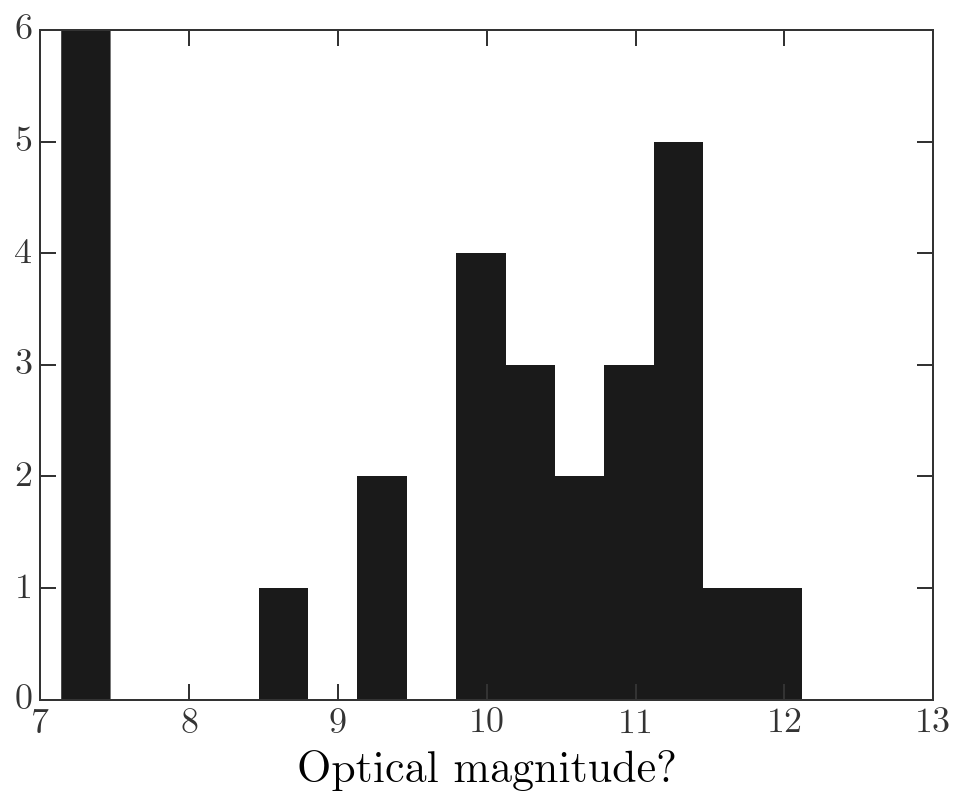

In [9]:
plt.figure(figsize=(8,6))
plt.hist(Gmag[match_idx], bins=15)
plt.xlabel('Optical magnitude?')

In [10]:
tgas_rave_matched = tgas_rave[match_idx]
len(tgas_rave_matched)

28

In [45]:
all_tgas_matched = tgas[all_match_idx]
len(all_tgas_matched)

372

Turn Gaia's correlation coefficients into a covariance matrix

In [11]:
def construct_mean_cov(gaia_data):
    """
    If the real data look like the simulated data, Gaia will provide 
    correlation coefficients and standard deviations for 
    (ra,dec,parallax,pm_ra,pm_dec), but we probably want to turn that
    into a covariance matrix.
    """
    names = ['ra', 'dec', 'parallax', 'pmra', 'pmdec']
    
    n = len(gaia_data['ra_error'])
    C = np.zeros((n,len(names),len(names)))
    mu = np.zeros((n,len(names)))
        
    # mean vectors
    for i,name in enumerate(names):
        mu[:,i] = gaia_data[name]
    
    # pre-load the diagonal
    for i,name in enumerate(names):
        full_name = "{}_error".format(name)
        C[:,i,i] = gaia_data[full_name]**2
    
    for i,name1 in enumerate(names):
        for j,name2 in enumerate(names):
            if j <= i: continue    
            full_name = "{}_{}_corr".format(name1, name2)
            C[...,i,j] = gaia_data[full_name]*np.sqrt(C[...,i,i]*C[...,j,j])
            C[...,j,i] = gaia_data[full_name]*np.sqrt(C[...,i,i]*C[...,j,j])
    
    return mu,C

In [12]:
mean,cov = construct_mean_cov(tgas_rave_matched)

In [46]:
all_mean,all_cov = construct_mean_cov(all_tgas_matched)

Integrate orbits of host stars in a Milky Way-like grav. potential:

In [13]:
# Milky Way potential
mw_potential = gp.CCompositePotential()

mw_potential['disk'] = gp.MiyamotoNagaiPotential(m=6E10, a=3.5, b=0.14, units=galactic)
mw_potential['bulge'] = gp.HernquistPotential(m=1E10, c=1.1, units=galactic)

# for DM halo potential
M_h = 8E11 * u.Msun
rs_h = 20. * u.kpc
v_c = np.sqrt(((np.log(2.) - 0.5) * (G * M_h / rs_h)).decompose(galactic).value)
mw_potential['halo'] = gp.SphericalNFWPotential(v_c=v_c, r_s=rs_h, units=galactic)

In [98]:
n_samples = 256

all_E = np.zeros((mean.shape[0],n_samples))
all_Lz = np.zeros((mean.shape[0],n_samples))
all_Lmag = np.zeros((mean.shape[0],n_samples))
all_ecc = np.zeros((mean.shape[0],n_samples))

for i in range(mean.shape[0]):
    samples = np.random.multivariate_normal(mean[0], cov[0], size=n_samples)
    rv = np.random.normal(tgas_rave_matched['HRV'][0], tgas_rave_matched['HRV'][0], size=n_samples) * u.km/u.s
    c = coord.ICRS(ra=samples[:,0]*u.degree, dec=samples[:,1]*u.degree, 
                   distance=(samples[:,2]*u.mas).to(u.pc, equivalencies=u.parallax()))
    pm = samples[:,3:5].T*u.mas/u.yr
    
    xyz = c.transform_to(coord.Galactocentric).cartesian.xyz
    vxyz = gc.vhel_to_gal(c, pm=pm, rv=rv)
    
    w0 = gd.CartesianPhaseSpacePosition(pos=xyz, vel=vxyz)
    orbit = mw_potential.integrate_orbit(w0, dt=-1., n_steps=1000)
    all_ecc[i] = [orbit[:,k].eccentricity().value for k in range(n_samples)]
    
    Lmag = np.sqrt(np.sum(w0.angular_momentum()**2, axis=0))
    Lz = w0.angular_momentum()[2]
    E = w0.energy(mw_potential)
    
    all_E[i] = E.to((u.km/u.s)*(u.kpc/u.Myr)).value
    all_Lz[i] = Lz.to(u.km/u.s*u.kpc).value
    all_Lmag[i] = Lmag.to(u.km/u.s*u.kpc).value
    
w0 = gd.CartesianPhaseSpacePosition(pos=[-8.3,0,0]*u.kpc, vel=[0,220,0]*u.km/u.s)
sun_Lmag = np.sqrt(np.sum(w0.angular_momentum()**2, axis=0)).to(u.km/u.s*u.kpc).value
sun_Lz = w0.angular_momentum()[2].to(u.km/u.s*u.kpc).value
sun_E = w0.energy(mw_potential).to((u.km/u.s)*(u.kpc/u.Myr)).value

In [37]:
ELLz = np.stack((all_E.ravel(), all_Lmag.ravel(), all_Lz.ravel())).T
sun_ELLz = np.concatenate((sun_E, sun_Lmag, sun_Lz))

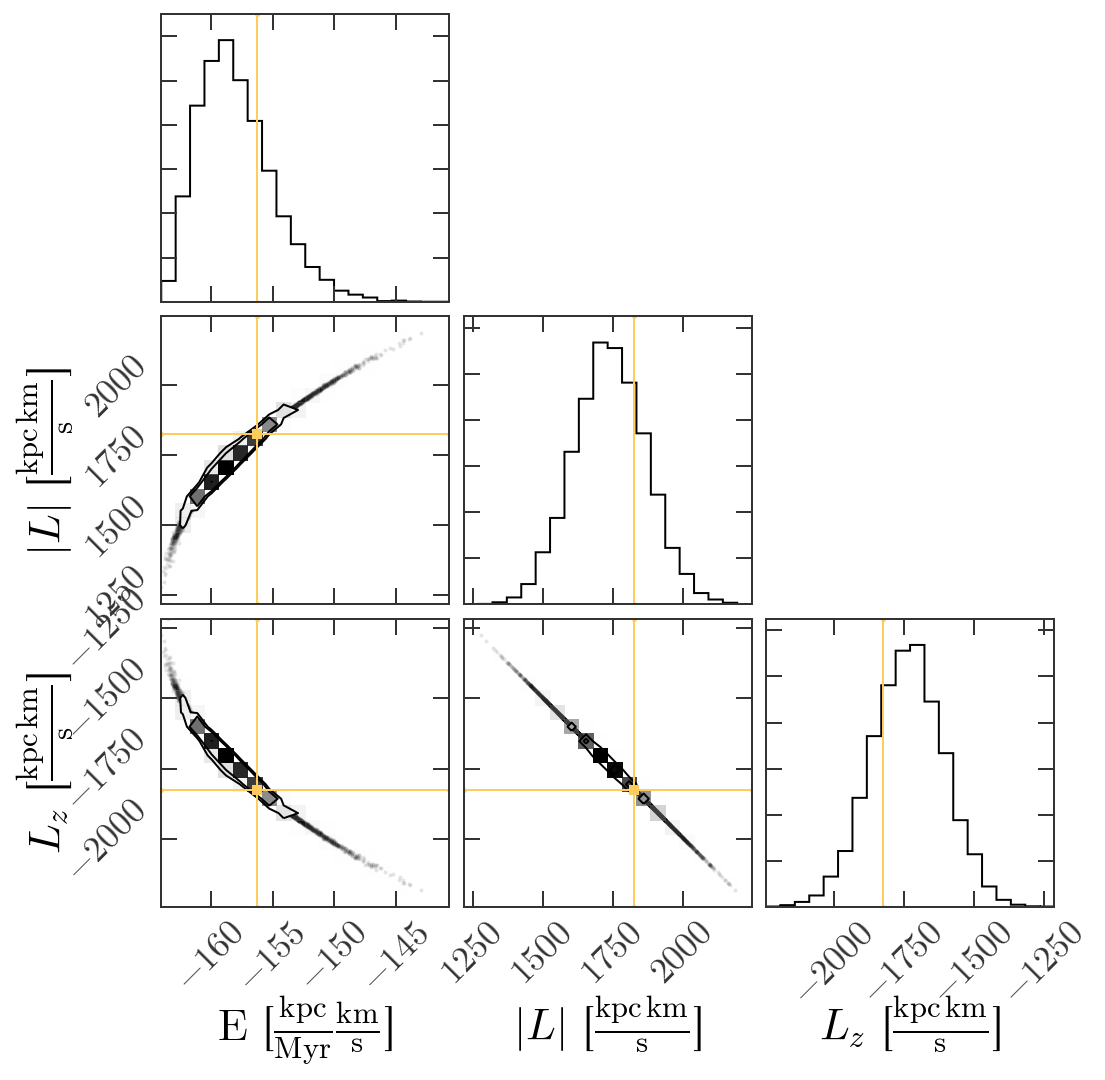

In [38]:
labels = [r'E [$\frac{\rm kpc}{\rm Myr}\frac{\rm km}{\rm s}$]',
          r'$|L|$ [$\frac{\rm kpc\,km}{\rm s}$]',
          r'$L_z$ [$\frac{\rm kpc\,km}{\rm s}$]']
fig = corner.corner(ELLz, truths=sun_ELLz, labels=labels, truth_color='#fecc5c')

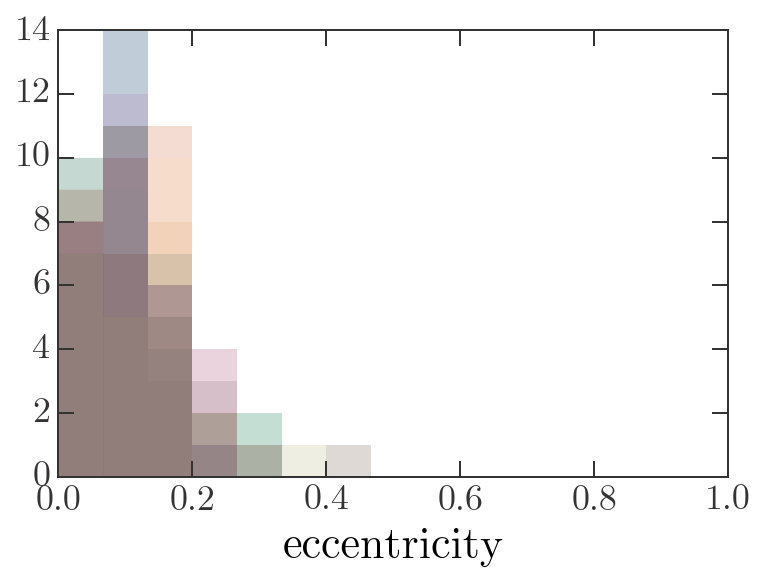

In [107]:
for i in range(16):
    plt.hist(all_ecc[:,i], bins=np.linspace(0,1,16), alpha=0.1);
plt.xlabel('eccentricity')

---

Where are all RAVE stars?

In [59]:
parallax = tgas_rave['parallax'] * u.mas
parallax_err = tgas_rave['parallax_error']*u.mas

pm = np.vstack((tgas_rave['pmra'], tgas_rave['pmdec'])) * u.mas/u.yr
pm_err = np.vstack((tgas_rave['pmra_error'], tgas_rave['pmdec_error'])) * u.mas/u.yr

clean_idx = (parallax_err / parallax) < 0.1
clean_tgas = tgas_rave[clean_idx]

In [60]:
all_c = coord.ICRS(ra=clean_tgas['ra']*u.deg, dec=clean_tgas['dec']*u.deg,
                   distance=(clean_tgas['parallax']*u.mas).to(u.kpc, u.parallax()))
all_xyz = all_c.transform_to(coord.Galactocentric).cartesian.xyz
all_vxyz = gc.vhel_to_gal(all_c, pm=np.vstack((clean_tgas['pmra'],clean_tgas['pmdec']))*u.mas/u.yr,
                          rv=clean_tgas['HRV']*u.km/u.s)

In [62]:
all_rave = gd.CartesianPhaseSpacePosition(pos=all_xyz, vel=all_vxyz)

In [64]:
E_rave = all_rave.energy(mw_potential).to(u.kpc*u.km/u.s/u.Myr).value
L_rave = all_rave.angular_momentum().to(u.kpc*u.km/u.s).value
Lmag_rave = np.sqrt(np.sum(L_rave**2, axis=0))
Lz_rave = L_rave[2]
rave_ELLz = np.vstack((E_rave, Lmag_rave, Lz_rave)).T

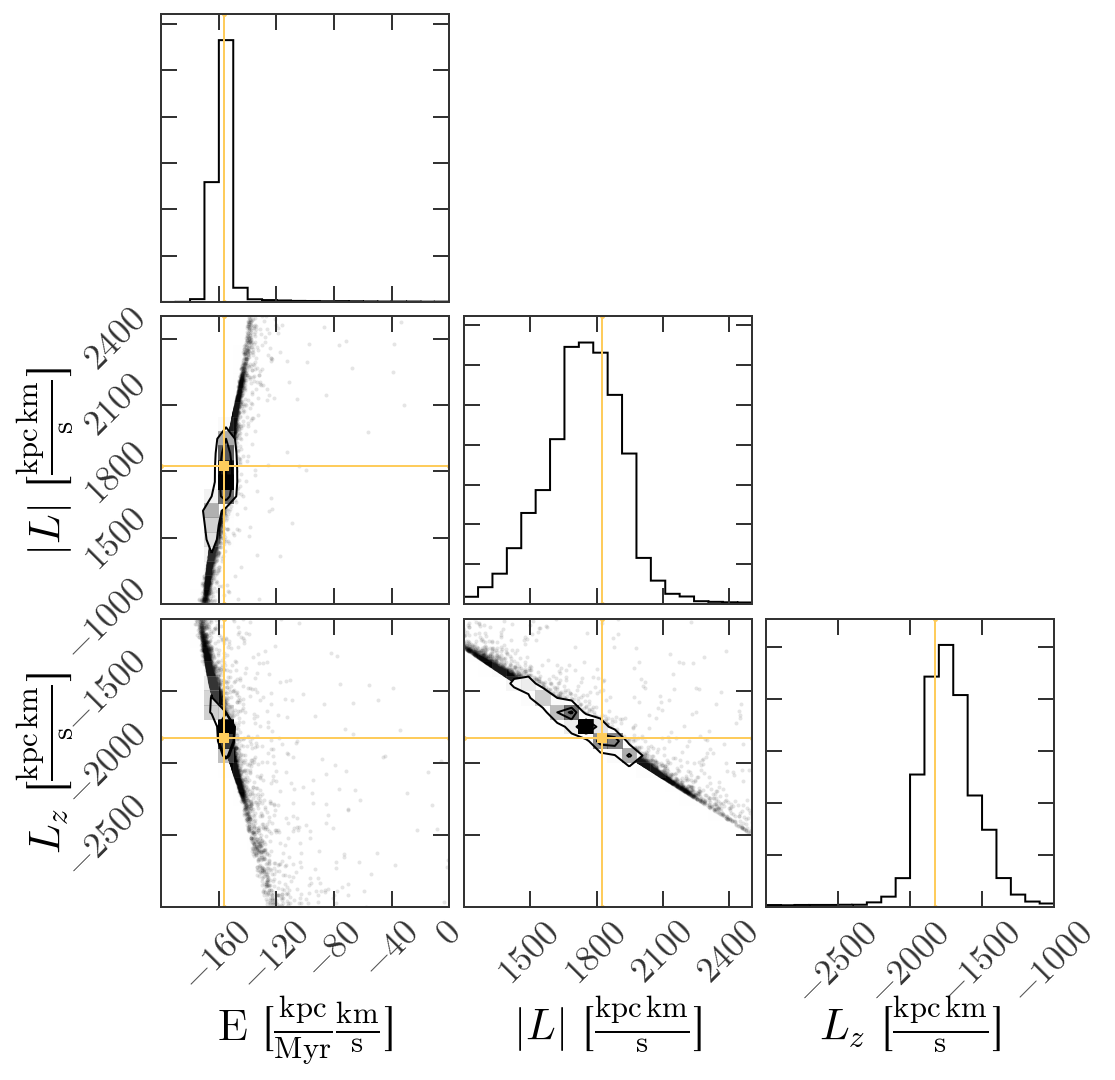

In [66]:
labels = [r'E [$\frac{\rm kpc}{\rm Myr}\frac{\rm km}{\rm s}$]',
          r'$|L|$ [$\frac{\rm kpc\,km}{\rm s}$]',
          r'$L_z$ [$\frac{\rm kpc\,km}{\rm s}$]']
fig = corner.corner(rave_ELLz, truths=sun_ELLz, labels=labels, truth_color='#fecc5c',
                    range=[(-200,0), (1200,2500), (-3000,-1000)])